# Imports

In [1]:
import os
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import random
import numpy as np
import string
import matplotlib.pyplot as plot
from scipy.stats import kstest,levene,ttest_rel, wilcoxon

#pytorch modules
import torch
from torch import load
from torchvision.utils import save_image
from torchvision import transforms
from torch.nn import MSELoss
from ignite.metrics import SSIM

#local modules
from configs import *
from utils import create_dirs_logs, compute_fid, compute_mse, save_list_table, draw_red_square, save_list_table
from data.common import unfold_image, fold_image, load_image_to_tensor, attention_mask_from_font

from models.diffusion_model import UNet

# Transform generated glyphs to complete fonts in a single image

In [3]:
source_dir="/home/francisco/logs/diffusion/default_conditional/test"
target_dir="/home/francisco/logs/diffusion/default_conditional/test_flat"
Path(target_dir).mkdir(exist_ok=True, parents=True)

fonts_list=os.listdir(os.path.join(source_dir,'0'))
for font_name in tqdm(fonts_list):
    font=torch.ones((1, 64, 64*26))
    for glyph_number in range(26):
        glyph=load_image_to_tensor(os.path.join(source_dir,str(glyph_number), font_name), unsqueeze=False, device='cpu')
        font[0, :, glyph_number*64:(glyph_number+1)*64] = glyph
    font=transforms.Lambda(lambda t: -t+1.)(font)
    save_image(font,os.path.join(target_dir,font_name))



# Random visuals

In [6]:
original_dir="/home/francisco/dataset/capitals64/test"
source_dir="/home/francisco/logs/diffusion/default_conditional/test_flat"
path_table="/home/francisco/logs/diffusion/default_conditional/data.txt"
data = []
meanMSE = 0
meanSSIM = 0

fonts_list=os.listdir(source_dir)
for font_name in tqdm(fonts_list):
    font_original=load_image_to_tensor(os.path.join(original_dir, font_name), unsqueeze=False, device='cuda:0')
    font_generated=load_image_to_tensor(os.path.join(source_dir, font_name), unsqueeze=False, device='cuda:0')

    mseLoss = MSELoss()
    mse = mseLoss(font_generated, font_original).tolist()
    meanMSE += mse

    ssimLoss = SSIM(data_range=1.0)
    ssimLoss.update((font_generated.unsqueeze(0), font_original.unsqueeze(0)))
    ssim = ssimLoss.compute()
    ssimLoss.reset()
    meanSSIM += ssim

    data.append([font_name[:-4], mse, ssim])

fid = compute_fid(original_dir, source_dir, batch_size=64, device='cuda:0')
data = [[meanMSE/len(fonts_list), meanSSIM/len(fonts_list), fid]]+data
save_list_table(path_table, data)

100%|██████████| 1560/1560 [01:02<00:00, 24.84it/s]
/home/francisco/miniconda3/envs/vae/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/francisco/miniconda3/envs/vae/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
 88%|████████▊ | 22/25 [03:19<00:46, 15.36s/it]

100%|██████████| 25/25 [02:19<00:00,  5.58s/it]


In [9]:
target_folder='/home/francisco/dataset/capitals64/test'
generated_folder='/home/francisco/logs/experiment2/subset_2_seed_0/test'
second_generated_folder='/home/francisco/logs/diffusion/default_conditional/test_flat'

device="cuda:0"
input_glyphs=[7, 14, 3, 18, 6, 17]
fonts=[
    "47-Bold.0.0",
    "1980 portable.0.0",
    "Adieresis, Odieresis & Aring 2.0.0",
    "advanced_led_board-7.0.0",
    "Alpha54.0.0",
    #"AnagramNFShadow.0.0",
    "Antique Book Cover.0.0",
    "ARACNE_regular_italic.0.0",
    "BeautySchoolDropoutII.0.0",
    "betsy flanagan.0.0",
    "blackout_sunrise-webfont.0.0",
    "brassknuckle.0.0",
    "brick_led-7.0.0",
    "computer_7.0.0",
    #"Cruickshank.0.0",
    "gosebmps.0.0",
    #Walbaum-Fraktur.0.0",
    #"yonder recoil.0.0",
    ]

fonts=[font+'.png' for font in fonts]

image=torch.ones(size=(3,3,1664),device=device, requires_grad=False)

for name in tqdm(fonts):
    target=load_image_to_tensor(os.path.join(target_folder, name), unsqueeze=False, device=device)
    target=torch.cat((target,target,target),dim=0)

    for elem in input_glyphs:
        target=draw_red_square(target,startX=0,startY=64*elem,width=64)
    
    generated=load_image_to_tensor(os.path.join(second_generated_folder, name), unsqueeze=False, device=device)
    generated=torch.cat((generated,generated,generated),dim=0)

    parcel=torch.cat((target,generated),dim=1)

    generated=load_image_to_tensor(os.path.join(generated_folder, name), unsqueeze=False, device=device)
    generated=torch.cat((generated,generated,generated),dim=0)

    parcel=torch.cat((parcel,generated),dim=1)
    if name!=fonts[0]:
        image=torch.cat((image,torch.ones(size=(3,30,1664),device=device)),dim=1)
    else:
        image=torch.cat((image,torch.ones(size=(3,3,1664),device=device)),dim=1)
    image=torch.cat((image,parcel),dim=1)

save_image(image, f'/home/francisco/logs/diffusion/default_conditional/visuals.png')

100%|██████████| 14/14 [00:00<00:00, 80.92it/s]


# Simulate diffusion process

In [ ]:
with torch.no_grad():
    glyph_path="/home/francisco/diffusion-model/glyph.png"

    model = UNet(image_channels=1,n_channels=64,ch_mults=[1,2,3,4], n_blocks=2, device='cuda:0', max_beta=0.02)
    beta= torch.linspace(0.0001, 0.02, 1000)
    
    for timestep in [0,200,400,600,800,999]:
        print(beta[timestep])
        print(timestep)
        target=load_image_to_tensor(glyph_path,unsqueeze=True,device='cuda:0')
        target=transforms.Lambda(lambda t: -t+1.)(target)
        target=transforms.Lambda(lambda t: (t*2.-1.))(target)
        t = torch.tensor([timestep], device='cuda:0')
        noise = torch.randn_like(target)

        xt = model.q_sample(target, t, eps=noise)
        xt=transforms.Lambda(lambda t: -t+1.)(xt)
        
        save_image(xt,f'visual_{str(timestep)}.png')
        torch.cuda.empty_cache()

# Interpolation

In [5]:
@torch.no_grad()
def sample(x: torch.Tensor, max_steps: int, model: UNet, content: torch.Tensor, style: torch.Tensor):
    # Remove noise for $T$ steps
    for t_ in range(max_steps):
        # $t$
        t = max_steps - t_ - 1
        # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
        timestamps=x.new_full((x.size(0),), t, dtype=torch.long)
        x = model.p_sample(x, timestamps , content, style)

    return x

#source1="ArbuckleInlineNF.0.0.pt"
source1="affection_ldr.0.0.pt"
source2="Alpha54.0.0.pt"
path_checkpoint="/home/francisco/logs/diffusion/default_conditional/Checkpoints/last.pt"
device="cuda:0"
glyph=1
image_name="step1.png"
model = load(path_checkpoint, map_location=torch.device(device))
model.eval()

for i,weight in tqdm(enumerate(np.arange(0,1.05,0.05))):
    content=torch.Tensor([glyph]).long().unsqueeze(0).to(device)

    style_path1=os.path.join("/home/francisco/dataset/capitals64Features/test",source1)
    style1=torch.load(style_path1, map_location='cpu').unsqueeze(0).to(device)

    style_path2=os.path.join("/home/francisco/dataset/capitals64Features/test",source2)
    style2=torch.load(style_path2, map_location='cpu').unsqueeze(0).to(device)
    
    interp_style=torch.lerp(style1,style2,weight=weight)

    output=sample(torch.randn([1,1,64,64], device=device),1000,model,content, interp_style)
    output=transforms.Lambda(lambda t: -t+1.)(output)
    path_to_save_image = Path(os.path.join("/home/francisco/logs/diffusion/default_conditional/interp1",f"step{i}.png"))
    path_to_save_image.parent.mkdir(exist_ok=True, parents=True)
    save_image(output[0], path_to_save_image)

21it [08:38, 24.70s/it]


In [5]:
@torch.no_grad()
def sample(x: torch.Tensor, max_steps: int, model: UNet, content: torch.Tensor, style: torch.Tensor):
    # Remove noise for $T$ steps
    for t_ in range(max_steps):
        # $t$
        t = max_steps - t_ - 1
        # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
        timestamps=x.new_full((x.size(0),), t, dtype=torch.long)
        x = model.p_sample(x, timestamps , content, style)

    return x

source1="aramisi.0.0.pt"
source2="Bauchaomaicha.0.0.pt"
path_checkpoint="/home/francisco/logs/diffusion/default_conditional/Checkpoints/last.pt"
device="cuda:0"
glyph=1
image_name="step1.png"
model = load(path_checkpoint, map_location=torch.device(device))
model.eval()

for i,weight in tqdm(enumerate(np.arange(0,1.05,0.05))):
    content=torch.Tensor([glyph]).long().unsqueeze(0).to(device)

    style_path1=os.path.join("/home/francisco/dataset/capitals64Features/test",source1)
    style1=torch.load(style_path1, map_location='cpu').unsqueeze(0).to(device)

    style_path2=os.path.join("/home/francisco/dataset/capitals64Features/test",source2)
    style2=torch.load(style_path2, map_location='cpu').unsqueeze(0).to(device)
    
    interp_style=torch.lerp(style1,style2,weight=weight)

    output=sample(torch.randn([1,1,64,64], device=device),1000,model,content, interp_style)
    output=transforms.Lambda(lambda t: -t+1.)(output)
    path_to_save_image = Path(os.path.join("/home/francisco/logs/diffusion/default_conditional/interp2",f"step{i}.png"))
    path_to_save_image.parent.mkdir(exist_ok=True, parents=True)
    save_image(output[0], path_to_save_image)

1it [00:38, 38.20s/it]


KeyboardInterrupt: 

# Dataset Experiment

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


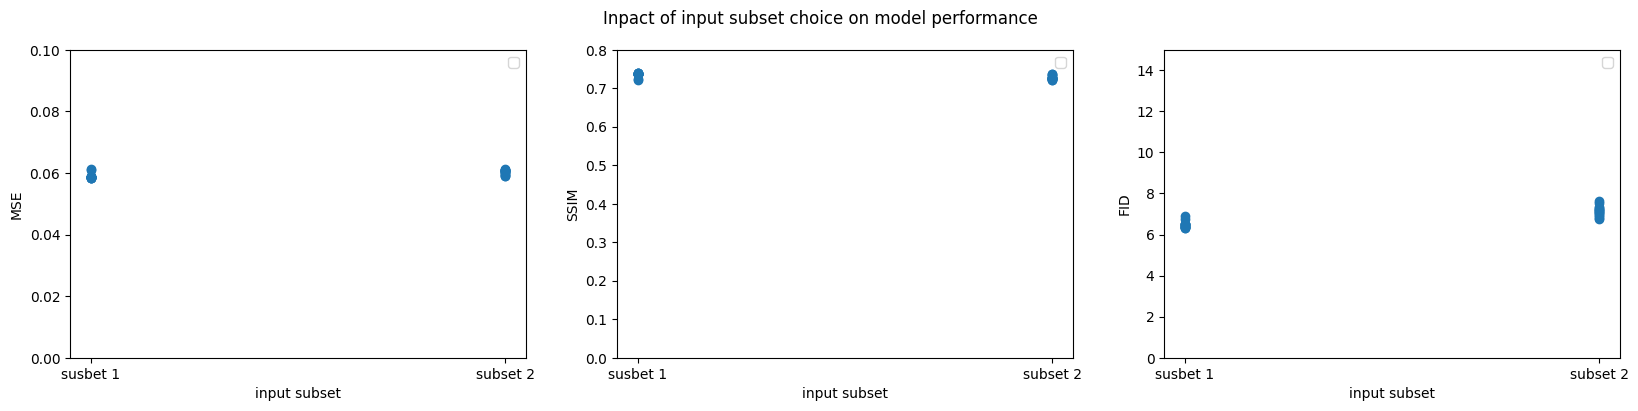

In [3]:
values={'mse':{'1':[],'2':[]}, 'fid':{'1':[],'2':[]}, 'ssim':{'1':[],'2':[]} }

for model in ['1','2']:
        for seed in range(0,15):
            file=open(f"/home/francisco/logs/experiment4/var{model}_seed_{seed}/data.txt")
            lines=file.readlines()
            mse,ssim,fid= lines[0].strip().split()
            values['fid'][model]+=[float(fid)]
            values['mse'][model]+=[float(mse)]
            values['ssim'][model]+=[float(ssim)]


scatter_x_mse=[1 for i in range(15)]+ [2 for i in range(15)]
scatter_y_mse=values['mse']['1'] + values['mse']['2']

scatter_x_ssim=[1 for i in range(15)]+ [2 for i in range(15)]
scatter_y_ssim=values['ssim']['1'] + values['ssim']['2']

scatter_x_fid=[1 for i in range(15)]+ [2 for i in range(15)]
scatter_y_fid=values['fid']['1'] + values['fid']['2']

fig, (ax1, ax2,ax3) = plot.subplots(1, 3,figsize = (20,4))
fig.suptitle('Inpact of input subset choice on model performance')

ax1.scatter(x=scatter_x_mse,y=scatter_y_mse)
ax2.scatter(x=scatter_x_ssim,y=scatter_y_ssim)
ax3.scatter(x=scatter_x_fid,y=scatter_y_fid)

ax1.set_xticks([1,2], ['susbet 1', 'subset 2'])
ax2.set_xticks([1,2], ['susbet 1', 'subset 2'])
ax3.set_xticks([1,2], ['susbet 1', 'subset 2'])

ax1.set_xlabel('input subset')
ax1.set_ylabel('MSE')
ax1.set_ylim([0,0.1])

ax2.set_xlabel('input subset')
ax2.set_ylabel('SSIM')
ax2.set_ylim([0,0.8])


ax3.set_xlabel('input subset')
ax3.set_ylabel('FID')
ax3.set_ylim([0,15])

ax1.legend()
ax2.legend()
ax3.legend()
plot.show()

In [4]:
values={'mse':{'1':[],'2':[]}, 'fid':{'1':[],'2':[]}, 'ssim':{'1':[],'2':[]} }
round_value=4
for model in ['1','2']:
        for seed in range(0,15):
            file=open(f"/home/francisco/logs/experiment4/var{model}_seed_{seed}/data.txt")
            lines=file.readlines()
            mse,ssim,fid= lines[0].strip().split()
            values['fid'][model]+=[float(fid)]
            values['mse'][model]+=[float(mse)]
            values['ssim'][model]+=[float(ssim)]

for seed in range(0,15):
    print(f"{seed} & {round(values['mse']['1'][seed],round_value)} & {round(values['fid']['1'][seed],round_value)} & {round(values['ssim']['1'][seed],round_value)} & {round(values['mse']['2'][seed],round_value)} & {round(values['fid']['2'][seed],round_value)} & {round(values['ssim']['2'][seed],round_value)}\\\\")

print(f"{np.round(np.mean(np.array(values['mse']['1'])),round_value)} & {np.round(np.mean(np.array(values['fid']['1'])),round_value)} & {np.round(np.mean(np.array(values['ssim']['1'])),round_value)} & {np.round(np.mean(np.array(values['mse']['2'])),round_value)} & {np.round(np.mean(np.array(values['fid']['2'])),round_value)} & {np.round(np.mean(np.array(values['ssim']['2'])),round_value)}")  
print(f"{np.round(np.std(np.array(values['mse']['1'])),round_value)} & {np.round(np.std(np.array(values['fid']['1'])),round_value)} & {np.round(np.std(np.array(values['ssim']['1'])),round_value)} & {np.round(np.std(np.array(values['mse']['2'])),round_value)} & {np.round(np.std(np.array(values['fid']['2'])),round_value)} & {np.round(np.std(np.array(values['ssim']['2'])),round_value)}")      

0 & 0.0586 & 6.4726 & 0.7377 & 0.059 & 6.7706 & 0.736\\
1 & 0.0586 & 6.5201 & 0.7376 & 0.06 & 6.9277 & 0.7263\\
2 & 0.0584 & 6.3874 & 0.7392 & 0.0589 & 6.811 & 0.7358\\
3 & 0.0613 & 6.774 & 0.7224 & 0.0608 & 7.1951 & 0.7252\\
4 & 0.0586 & 6.3274 & 0.7373 & 0.0603 & 7.3632 & 0.7262\\
5 & 0.0586 & 6.311 & 0.7387 & 0.0611 & 7.5283 & 0.7226\\
6 & 0.0585 & 6.5253 & 0.7372 & 0.0608 & 7.117 & 0.7248\\
7 & 0.0585 & 6.5246 & 0.739 & 0.061 & 7.6132 & 0.7211\\
8 & 0.0587 & 6.3714 & 0.7371 & 0.0605 & 7.0646 & 0.7273\\
9 & 0.0586 & 6.4264 & 0.7377 & 0.0606 & 7.129 & 0.7242\\
10 & 0.0587 & 6.4417 & 0.7372 & 0.0597 & 6.8921 & 0.7325\\
11 & 0.0608 & 6.8856 & 0.7252 & 0.0593 & 7.034 & 0.7338\\
12 & 0.0584 & 6.3877 & 0.7383 & 0.0605 & 7.1712 & 0.7253\\
13 & 0.059 & 6.3867 & 0.7364 & 0.061 & 7.313 & 0.7256\\
14 & 0.0585 & 6.5104 & 0.7376 & 0.0607 & 7.2558 & 0.7269\\
0.0589 & 6.4835 & 0.7359 & 0.0603 & 7.1457 & 0.7276
0.0009 & 0.153 & 0.0048 & 0.0007 & 0.2367 & 0.0045


In [2]:
@torch.no_grad()
def sample(x: torch.Tensor, max_steps: int, model: torch.nn.Module, content: torch.Tensor, style: torch.Tensor):
    # Remove noise for $T$ steps
    for t_ in range(max_steps):
        # $t$
        t = max_steps - t_ - 1
        # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
        timestamps=x.new_full((x.size(0),), t, dtype=torch.long)
        x = model.p_sample(x, timestamps , content, style)

    return x

#/home/francisco/dataset/capitals64/test/Alpha54.0.0.png
source1="/home/francisco/dataset/capitals64/test/Antique Book Cover.0.0.png"
source2="../dataset/capitals64Features/test/Antique Book Cover.0.0.pt"
path_checkpoint="../logs/diffusion/default_conditional/Checkpoints/last.pt"
device="cuda:0"

model = load(path_checkpoint, map_location=torch.device(device))
model.eval()
print("loaded model")

final=torch.ones((1, 64, 1664)).to(device)
for glyph in tqdm(range(26)):
    content=torch.Tensor([glyph]).long().unsqueeze(0).to(device)

    style=torch.load(source2, map_location=device).unsqueeze(0).to(device)
    output=sample(torch.randn([1,1,64,64], device=device),1000,model,content, style)
    output=transforms.Lambda(lambda t: -t+1.)(output)
    final[0, :, glyph*64:(glyph+1)*64] = output
path_to_save_image = Path(os.path.join(f"test1.png"))
path_to_save_image.parent.mkdir(exist_ok=True, parents=True)
save_image(final, path_to_save_image)

loaded model


  0%|          | 0/26 [00:00<?, ?it/s]